to check the normalization of the QE is to cross-correlate QE with the true input kappa, and compare that with the power spectrum of the true kappa. The ratio should be unity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


In [87]:
print("Map properties")

# number of pixels for the flat map
nX = 800 # 1200
nY = 800 #1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [88]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [90]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [91]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


In [92]:
cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)

tmp_lCen, _, _ = baseMap.powerSpectrum(cmb0Fourier)

/code/delon/LensQuEst/LensQuEst/cmb.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/code/delon/LensQuEst/LensQuEst/cmb.py:42: RuntimeWarning: invalid value encountered in scalar multiply
  self.funlensedTT = lambda l: (l>=lmin_unlensedCMB and l<=lmax_unlensedCMB) * self.funlensedTT_template(l) * self.fdl_to_cl(l)
/code/delon/LensQuEst/LensQuEst/flat_map.py:462: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)


In [93]:
data = [-1]
cnt = 0

In [ ]:
from tqdm import trange
for i in trange(100):
    cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
    cmb0 = baseMap.inverseFourier(cmb0Fourier)

    kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
    kCmb = baseMap.inverseFourier(kCmbFourier)

    lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
    lensedCmbFourier = baseMap.fourier(lensedCmb)

    fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
    lensedCmbFourier = lensedCmbFourier + fgFourier
    lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

    noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
    totalCmbFourier = lensedCmbFourier + noiseFourier
    totalCmb = baseMap.inverseFourier(totalCmbFourier)
    Cls = {}
    kap  = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, 
                                lMin=lMin, lMax=lMax,dataFourier=totalCmbFourier)
    Cls['kkT'] = [0,0,0]
    Cls['kkT'][0],Cls['kkT'][1],Cls['kkT'][2] = baseMap.crossPowerSpectrum(kap, kCmbFourier)
    if(data[0]==-1):
        data = np.zeros_like(Cls['kkT'][1])
    data += Cls['kkT'][1]/np.array(list(map(p2d_cmblens.fPinterp, Cls['kkT'][0])))
    cnt += 1

 21%|██        | 21/100 [36:13<2:00:27, 91.48s/it]]

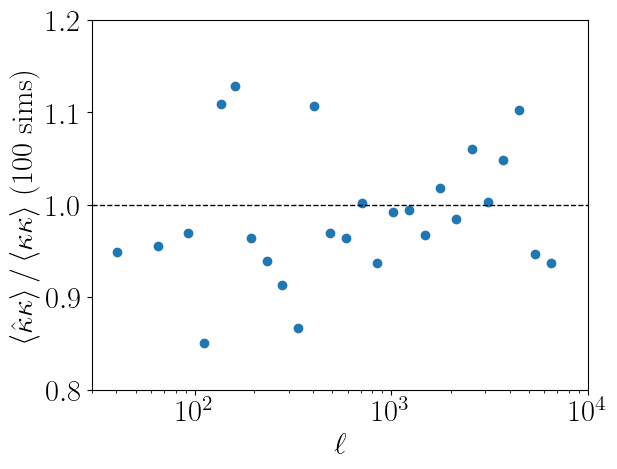

In [95]:
plt.scatter(tmp_lCen, data/cnt)
plt.xscale('log')
plt.xlabel(r'$\ell$')
# plt.yscale('log')
plt.ylabel(r'$\left<\hat\kappa \kappa\right>/\left<\kappa \kappa\right>$ (100 sims)')
plt.ylim(0.8,1.2)
plt.xlim(30,1e4)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.savefig('figures/khatk_over_kk_800x800_20x20.png')

In [83]:
print(baseMap.lx[0])

[[   0.    0.    0. ...    0.    0.    0.]
 [  36.   36.   36. ...   36.   36.   36.]
 [  72.   72.   72. ...   72.   72.   72.]
 ...
 [-108. -108. -108. ... -108. -108. -108.]
 [ -72.  -72.  -72. ...  -72.  -72.  -72.]
 [ -36.  -36.  -36. ...  -36.  -36.  -36.]]


In [85]:
print(baseMap.lx.max())

7200.0
